# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений и не только.

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## OpenCV
Библиотека для удобной работы с картинками

## Загрузка изображения

Загрузим изображение из интернета, например, мем про юккури.

In [4]:
! wget "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg" -O mona_lisa.jpg

--2024-11-08 18:17:50--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2a02:ec80:300:ed1a::2:b, 185.15.59.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2a02:ec80:300:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31371 (31K) [image/jpeg]
Saving to: ‘mona_lisa.jpg’

mona_lisa.jpg       100%[===================>]  30.64K  --.-KB/s    in 0.06s   

2024-11-08 18:17:50 (481 KB/s) - ‘mona_lisa.jpg’ saved [31371/31371]



## Чтение изображения

In [5]:
img = Image.open('./mona_lisa.jpg')

In [7]:
img.format

'JPEG'

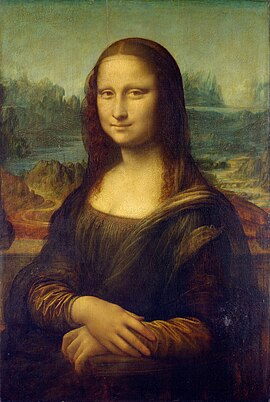

In [8]:
img.show()

In [9]:
img.size

(270, 402)

In [10]:
img.mode

'RGB'

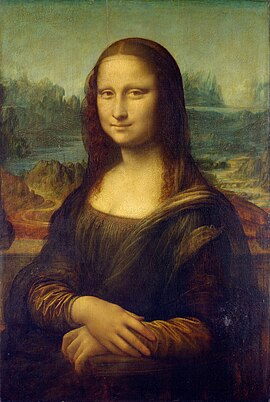

In [11]:
img

## Матричное представление

In [12]:
img_matrix = np.array(img)

In [13]:
img_matrix.shape

(402, 270, 3)

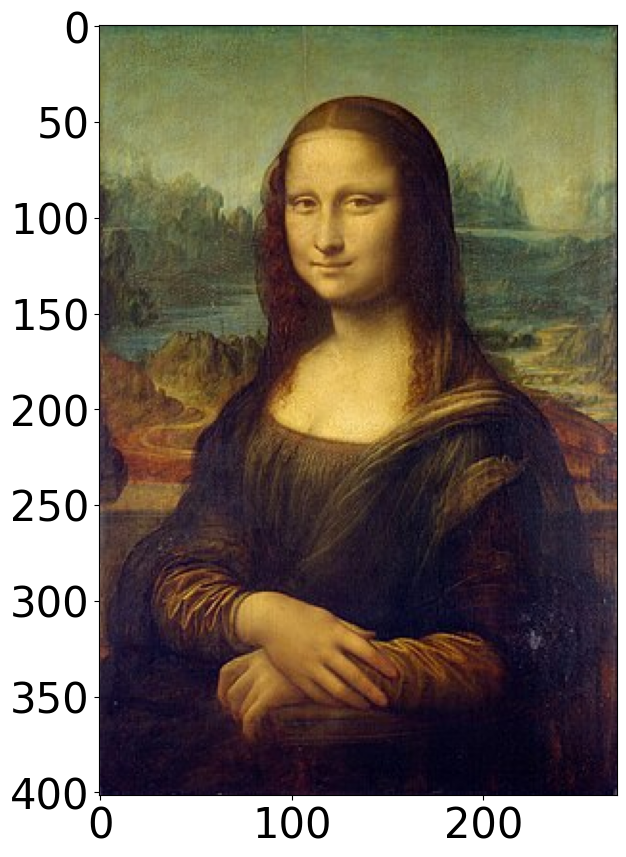

In [14]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

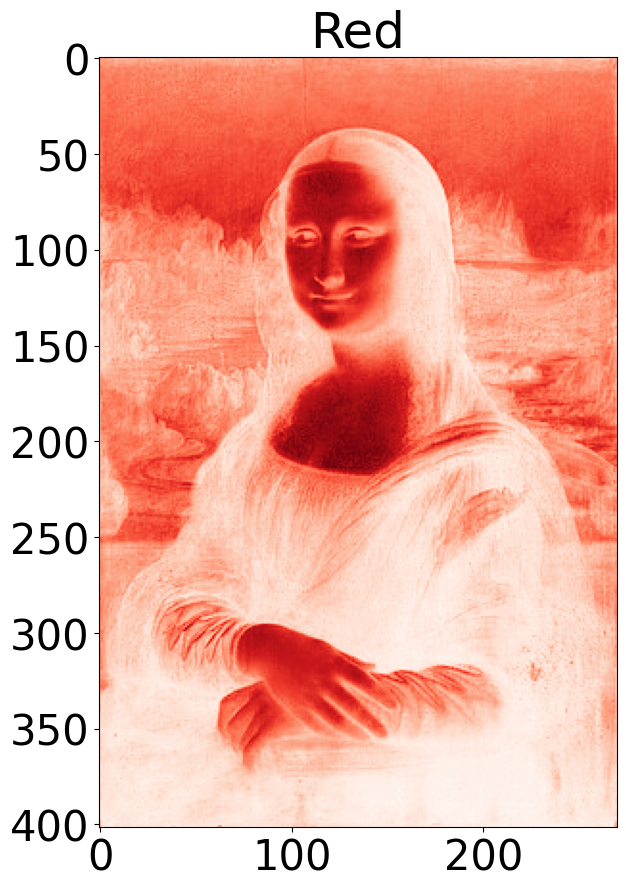

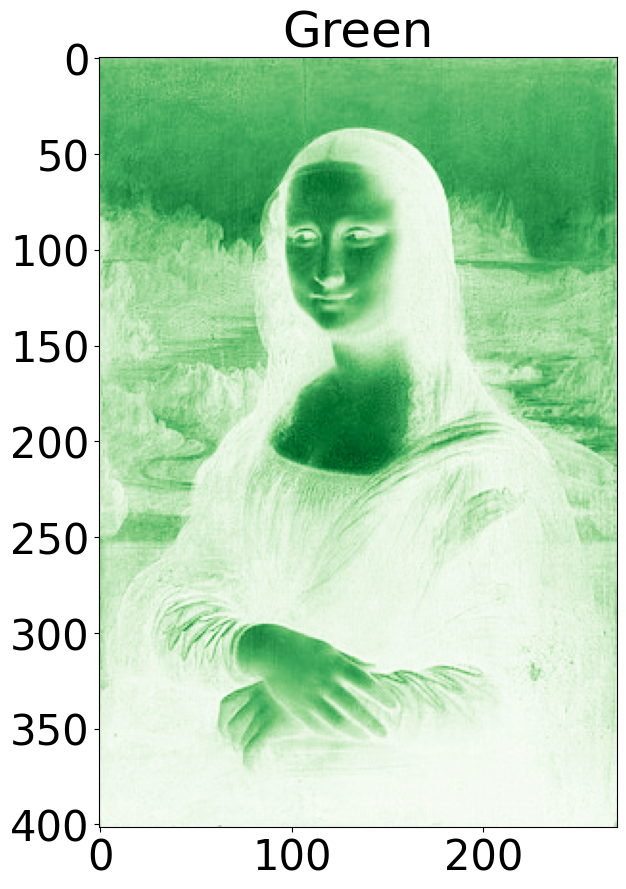

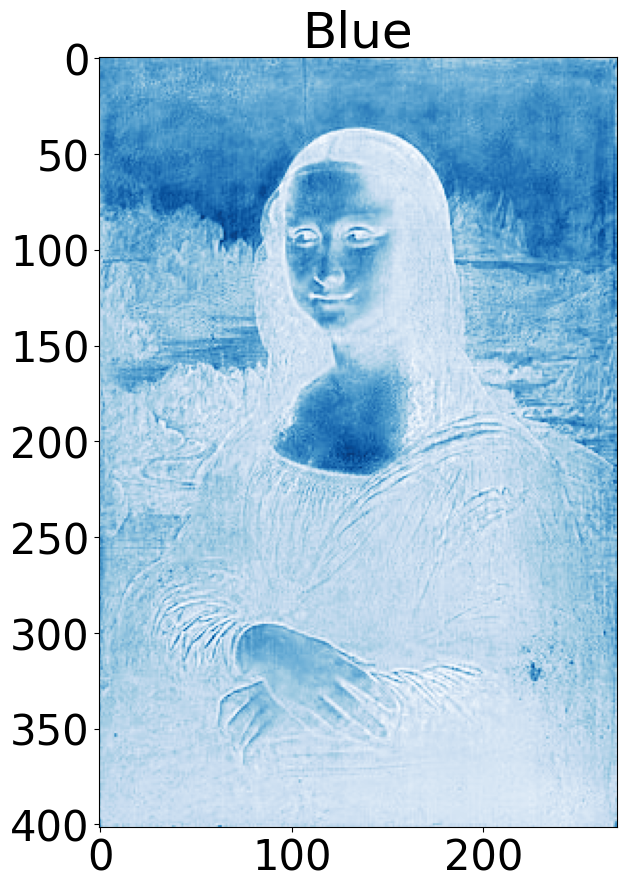

In [15]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [16]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

#### Математическая формула свертки:
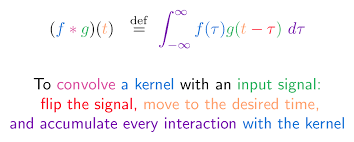
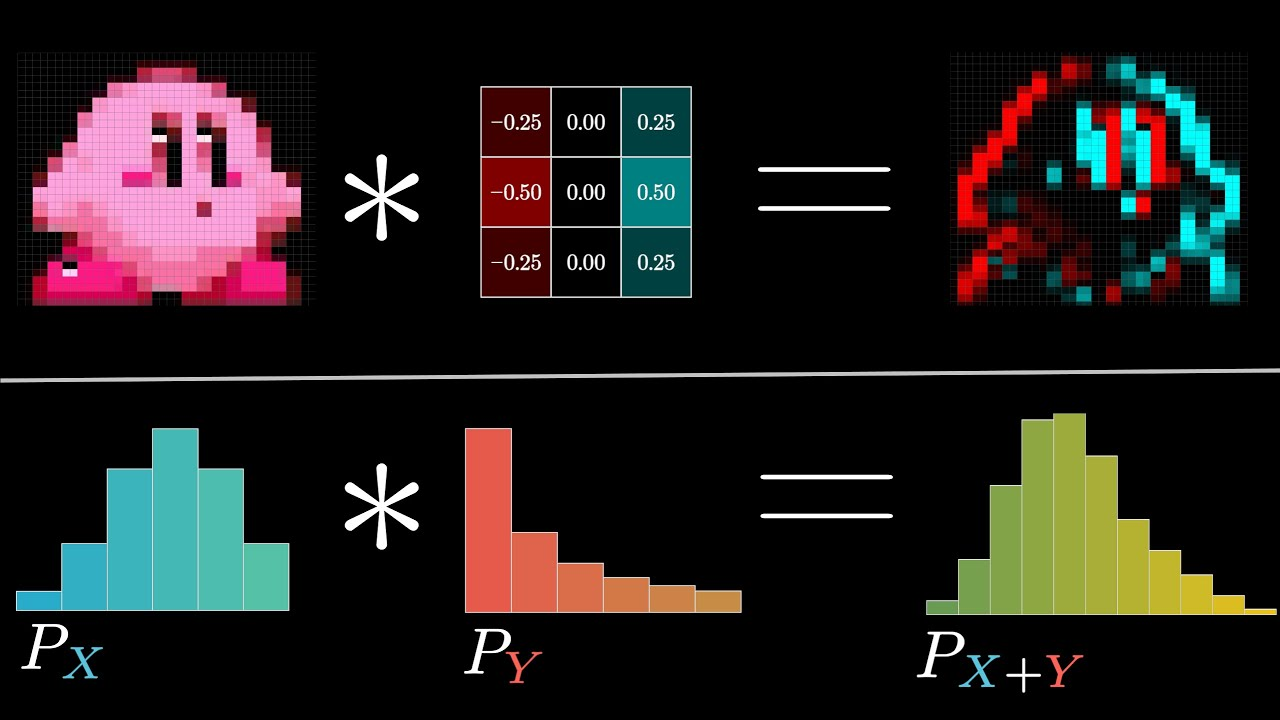


#### Формула свертки в торче:
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k), $$

Где:
- $\star$ - оператор кросс-корреляции (*почти*-свертка),
- $N$ - размер батча
- $C$ - количество каналов (входных и выхолных),
- $H$ - высота тензора в пикселях
- $W$ - ширина тензора в пикселях

#### Как рассчитываются итоговые шейпы:
$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$



- [Калькудятор расчета свертки](https://madebyollin.github.io/convnet-calculator/) (не тестил для всех возможных сценариев)
- https://www.youtube.com/@animatedai - У чувака красивые ролики про свертки и не только
- [Convolution explainer](https://poloclub.github.io/cnn-explainer/)


In [25]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
)

In [26]:
conv1.weight

Parameter containing:
tensor([[[[ 0.0980, -0.0534,  0.0857],
          [ 0.1392,  0.1151, -0.1827],
          [ 0.0252, -0.1413, -0.1254]],

         [[ 0.1181, -0.1853,  0.0652],
          [-0.0602, -0.1219,  0.0613],
          [-0.1745,  0.1049,  0.0663]],

         [[-0.0424,  0.0213,  0.0504],
          [-0.0548, -0.1541,  0.0620],
          [ 0.1688, -0.0819,  0.0814]]],


        [[[-0.0777,  0.1462,  0.0938],
          [-0.0406, -0.0918, -0.1534],
          [ 0.1094, -0.0795, -0.1883]],

         [[ 0.1017, -0.0805,  0.0051],
          [ 0.1752,  0.0892,  0.1217],
          [ 0.0867,  0.1905,  0.1024]],

         [[ 0.1406,  0.1017,  0.1193],
          [ 0.1210,  0.0437,  0.1259],
          [-0.1813,  0.1652, -0.0139]]],


        [[[-0.0031, -0.0286, -0.1472],
          [-0.1543,  0.0821, -0.1564],
          [ 0.1600,  0.1478, -0.0659]],

         [[ 0.1131, -0.0393, -0.0890],
          [-0.1481,  0.1887, -0.0846],
          [-0.1738, -0.1665, -0.1010]],

         [[-0.1353, -0

In [27]:
conv1.weight.shape

torch.Size([10, 3, 3, 3])

In [28]:
conv1.bias.shape

torch.Size([10])

In [29]:
list(conv1.parameters())

[Parameter containing:
 tensor([[[[ 0.0980, -0.0534,  0.0857],
           [ 0.1392,  0.1151, -0.1827],
           [ 0.0252, -0.1413, -0.1254]],
 
          [[ 0.1181, -0.1853,  0.0652],
           [-0.0602, -0.1219,  0.0613],
           [-0.1745,  0.1049,  0.0663]],
 
          [[-0.0424,  0.0213,  0.0504],
           [-0.0548, -0.1541,  0.0620],
           [ 0.1688, -0.0819,  0.0814]]],
 
 
         [[[-0.0777,  0.1462,  0.0938],
           [-0.0406, -0.0918, -0.1534],
           [ 0.1094, -0.0795, -0.1883]],
 
          [[ 0.1017, -0.0805,  0.0051],
           [ 0.1752,  0.0892,  0.1217],
           [ 0.0867,  0.1905,  0.1024]],
 
          [[ 0.1406,  0.1017,  0.1193],
           [ 0.1210,  0.0437,  0.1259],
           [-0.1813,  0.1652, -0.0139]]],
 
 
         [[[-0.0031, -0.0286, -0.1472],
           [-0.1543,  0.0821, -0.1564],
           [ 0.1600,  0.1478, -0.0659]],
 
          [[ 0.1131, -0.0393, -0.0890],
           [-0.1481,  0.1887, -0.0846],
           [-0.1738, -0.1665, 

Одна из операций самых нужных трансформаций - переход к устоявшемуся тензорному представлению изображения в торче:

$$H \times W \times C \to C \times H \times W$$
$$[0, 255] \to [0, 1]$$


Ее осуществляет `T.ToTensor`:

In [32]:
?T.ToTensor

Init signature: T.ToTensor() -> None
Docstring:     
Convert a PIL Image or ndarray to tensor and scale the values accordingly.

This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.

.. note::
    Because the input image is scaled to [0.0, 1.0], this transformation should not be used when
    transforming target image masks. See the `references`_ for implementing the transforms for image masks.

.. _references: https://github.com/pytorch/vision/tree/main/references/segmentation
File:           ~/miniconda3/envs/graph_ts/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     

In [33]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [34]:
transform =  T.ToTensor()
img_tensor = transform(img).unsqueeze(0)

In [35]:
img_tensor.shape

torch.Size([1, 3, 402, 270])

In [36]:
output = conv1(img_tensor)

In [37]:
output.shape

torch.Size([1, 10, 400, 268])

In [43]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding="same", # == 1
)

In [39]:
output = conv2(img_tensor)

In [40]:
output.shape

torch.Size([1, 10, 402, 270])

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [47]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [50]:
img_tensor

tensor([[[1., 7., 8., 9., 8., 6., 5., 6., 7., 1.],
         [1., 8., 0., 4., 0., 7., 7., 5., 5., 4.],
         [0., 9., 5., 3., 5., 6., 7., 6., 7., 3.],
         [8., 6., 4., 6., 6., 1., 2., 6., 7., 6.],
         [5., 2., 1., 7., 0., 4., 4., 6., 3., 3.],
         [8., 7., 7., 3., 7., 6., 2., 0., 2., 3.],
         [0., 4., 8., 5., 1., 5., 1., 1., 7., 0.],
         [7., 4., 6., 1., 6., 0., 0., 2., 0., 7.],
         [0., 6., 7., 0., 4., 9., 7., 0., 1., 9.],
         [7., 9., 7., 4., 3., 4., 2., 8., 8., 4.]]])

In [51]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [52]:
pooling1(img_tensor)

tensor([[[8., 9., 8., 7., 7.],
         [9., 6., 6., 7., 7.],
         [8., 7., 7., 6., 3.],
         [7., 8., 6., 2., 7.],
         [9., 7., 9., 8., 9.]]])

In [53]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [54]:
pooling2(img_tensor)

tensor([[[4.2500, 5.2500, 5.2500, 5.7500, 4.2500],
         [5.7500, 4.5000, 4.5000, 5.2500, 5.7500],
         [5.5000, 4.5000, 4.2500, 3.0000, 2.7500],
         [3.7500, 5.0000, 3.0000, 1.0000, 3.5000],
         [5.5000, 4.5000, 5.0000, 4.2500, 5.5000]]])

## Датасет MNIST

In [55]:
mnist_train = MNIST(
    "./mnist",
    train=False,
    download=True
)

In [56]:
mnist_train.data.shape

torch.Size([10000, 28, 28])

In [57]:
mnist_train.test_labels.shape

torch.Size([10000])

In [59]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 7)

In [ ]:
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, *args, transform=None, **kwargs):
#         ...
#         self.transform = transform

#     def __getitem__(self, idx: int):
#         element = self.data[idx]
#         if self.transform is not None:
#             element = self.transform(element)
#         return element

In [62]:
mnist_train = MNIST(
    "./mnist",
    train=True,
    download=True,
    transform=T.Compose(
        [T.ToTensor(),
         T.Resize(28)]
    )
)

In [64]:
mnist_valid = MNIST(
    "./mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

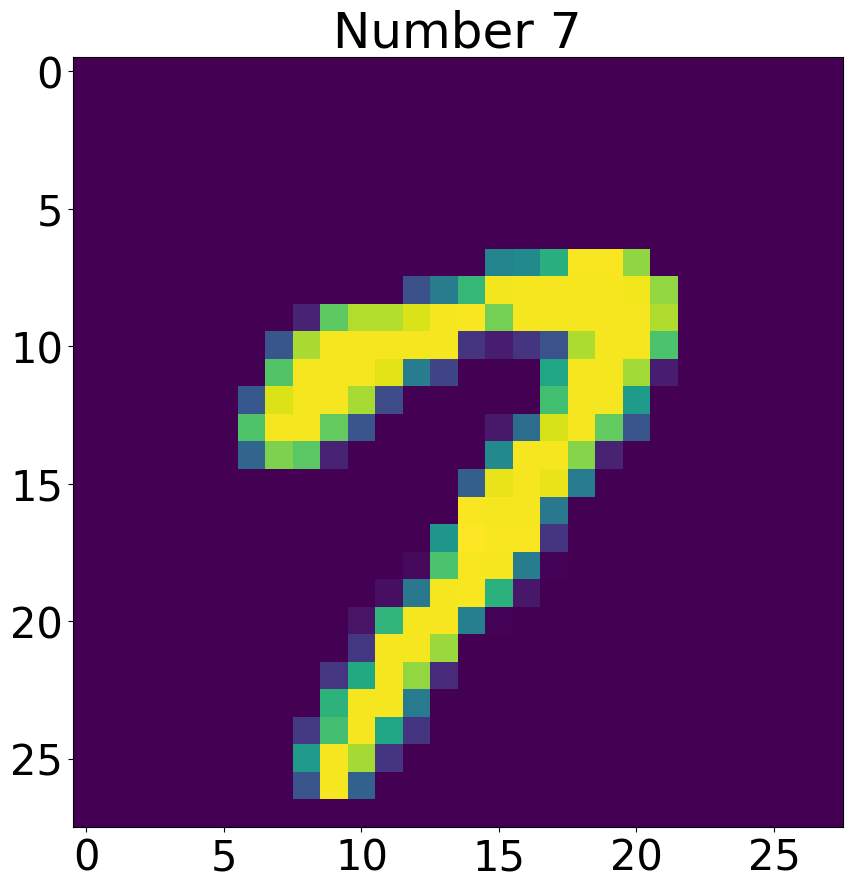

In [65]:
plt.figure(figsize=(10, 10))
plt.title(f'Number {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

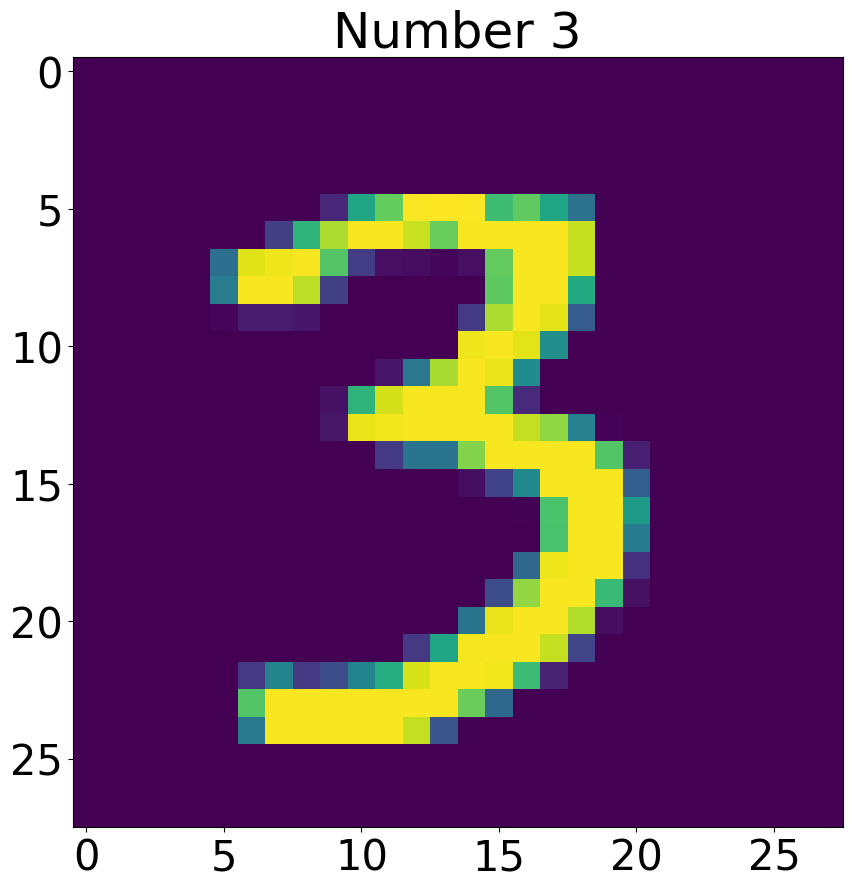

In [67]:
plt.figure(figsize=(10, 10))
plt.title(f'Number {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

In [68]:
len(mnist_train)

60000

In [69]:
len(mnist_valid)

10000

In [70]:
train_loader = DataLoader(mnist_train, batch_size=1024, shuffle=True, num_workers=12)
valid_loader = DataLoader(mnist_valid, batch_size=1024, shuffle=False, num_workers=12)

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [75]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [73]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x.to(DEVICE))

        loss = loss_fn(output, y.to(DEVICE))

        train_loss += loss.detach()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss.item()

In [76]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        y = y.to(DEVICE)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.detach()

        y_pred = torch.argmax(output, -1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss.item(), accuracy

In [77]:
def plot_stats(
    train_loss,
    valid_loss,
    valid_accuracy,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' valid accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [78]:
def get_number_of_model_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

In [79]:
class CustomSequential(nn.Sequential):
    def __init__(self, *layers):
        super().__init__(*layers)
        self._num_params = get_number_of_model_parameters(self)

        self.to(DEVICE)

        print(self)

    def __str__(self):
        return f"{'*'*75}\nModel:\n{self.__repr__()}\n\nNumber of parameters: {self._num_params}\n{'*'*75}"

    def forward(self, x):
        """
        This wrapper allows us to forget about handling devices mismatch at all OUTSIDE training loop
        
        !! Can be inconvenient for large models and in production
        """
        if x.device != DEVICE:
            x = x.to(DEVICE)
        return super().forward(x)

In [80]:
first_model = CustomSequential(
    nn.Flatten(),  # torch.reshape(B, -1)
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

***************************************************************************
Model:
CustomSequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=200, bias=True)
  (4): ReLU()
  (5): Linear(in_features=200, out_features=10, bias=True)
)

Number of parameters: 494710
***************************************************************************


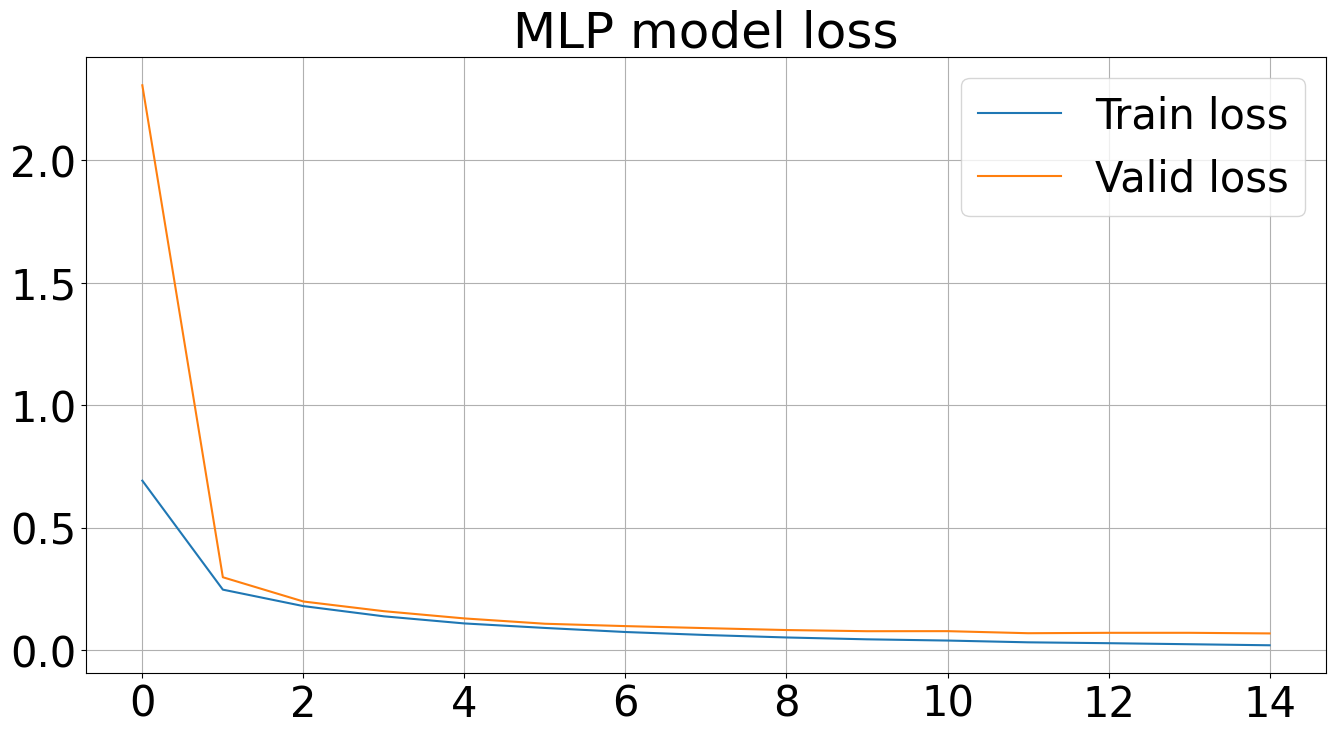

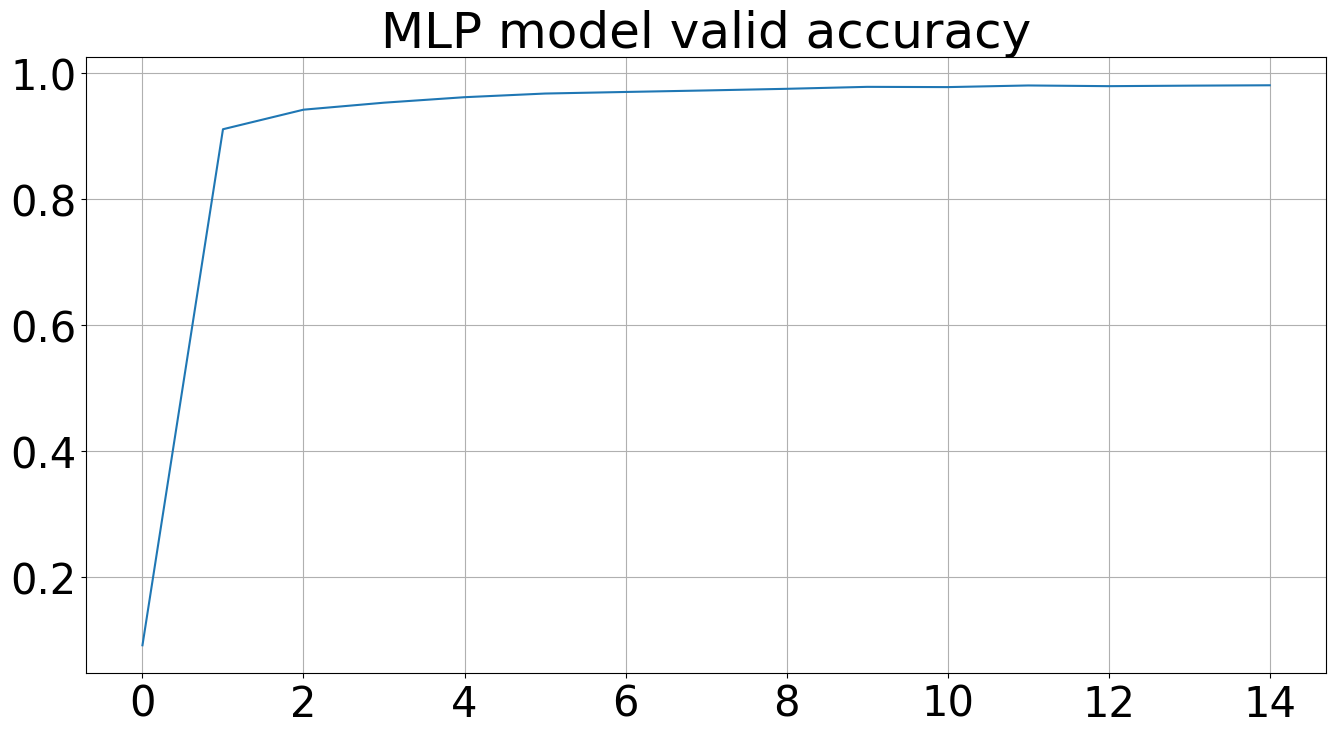

Evaluation: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s]

Total training and evaluation time 37.67554


In [81]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)
    
    train_loss = train(first_model)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    

valid_loss, valid_accuracy = evaluate(first_model, valid_loader)
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

## Сверточная сеть

In [82]:
second_model = CustomSequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28 -> 24*24
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #24*24 -> 12*12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5), # 12 - 5 + 1 = 8
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), # 8*8 -> 4*4
    
    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10),
)


x = torch.rand((1, 1, 28, 28))
print(x.shape)
print(second_model(x).shape)

***************************************************************************
Model:
CustomSequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=256, out_features=10, bias=True)
)

Number of parameters: 75194
***************************************************************************
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [87]:
second_model = CustomSequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28 -> 24*24
    nn.BatchNorm2d(16),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=2), #24*24 -> 12*12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5), #12*12 -> 8*8
    nn.BatchNorm2d(16),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), # 8*8 -> 4*4

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=7e-4)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

***************************************************************************
Model:
CustomSequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.2, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=256, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=256, out_features=10, bias=True)
)

Number of parameters: 75258
******************************************************************

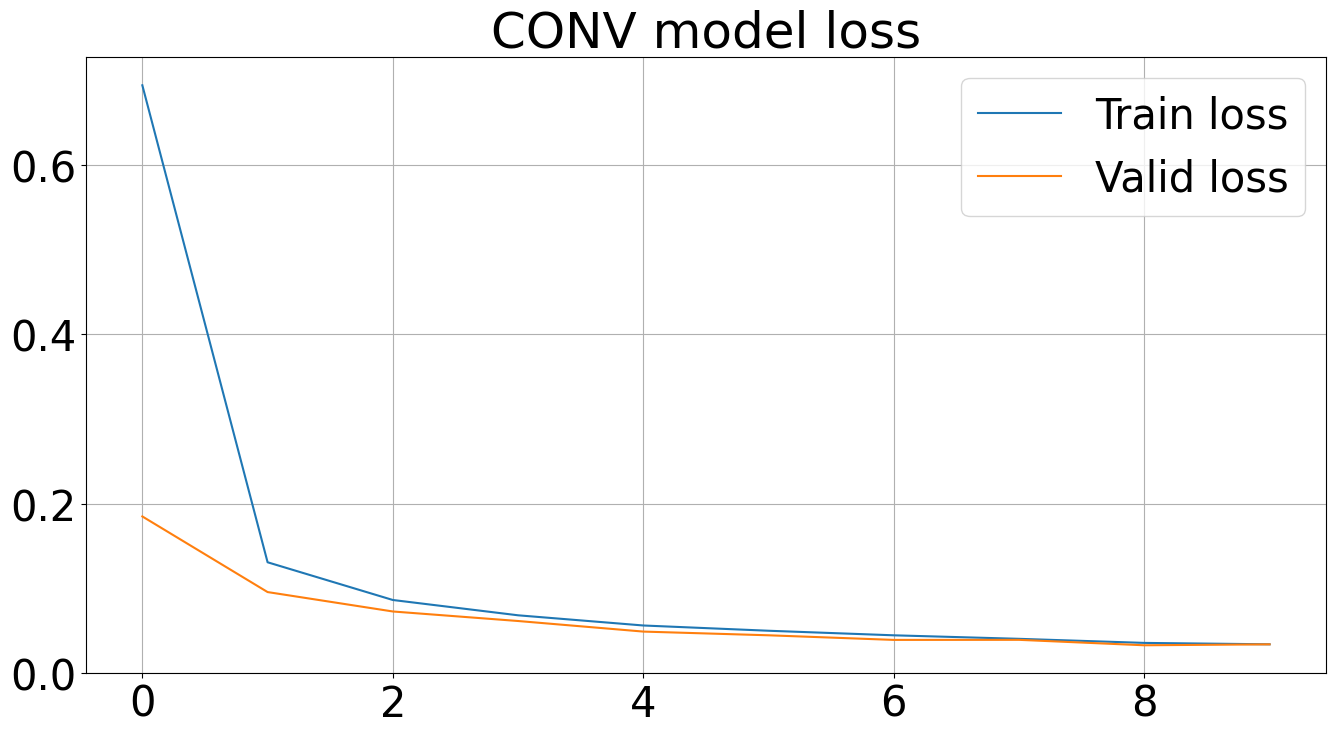

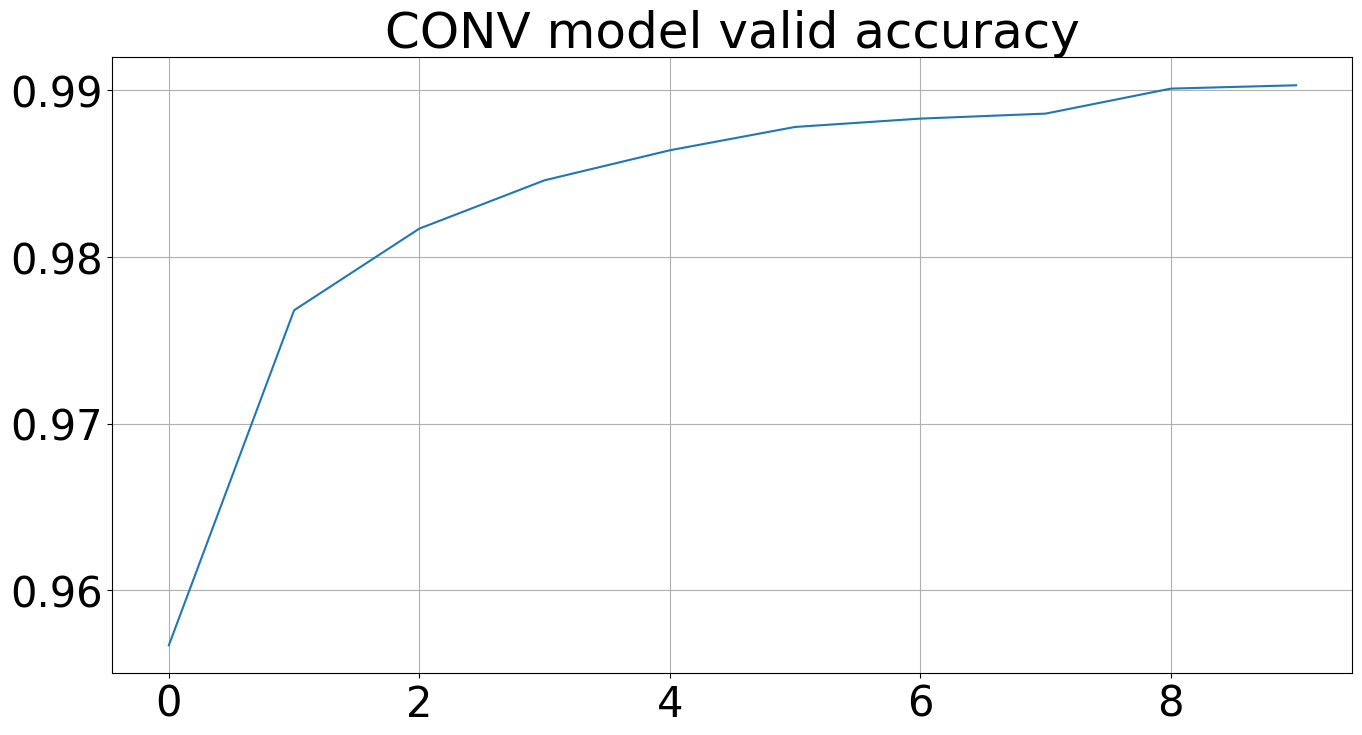

Total training and evaluation time 27.33709


In [88]:
num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [85]:
second_model.eval()

with torch.no_grad():
    for img, cls in valid_loader:
        print("predicted: ", torch.argmax(second_model(img)[:20], dim=-1).cpu())
        print("true:      ", cls[:20], end=f"\n\n{'*' * 80}\n\n")
        

predicted:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
true:       tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

********************************************************************************

predicted:  tensor([4, 1, 8, 1, 3, 8, 1, 2, 5, 8, 0, 6, 2, 1, 1, 2, 1, 5, 3, 4])
true:       tensor([4, 1, 8, 1, 3, 8, 1, 2, 5, 8, 0, 6, 2, 1, 1, 7, 1, 5, 3, 4])

********************************************************************************

predicted:  tensor([7, 9, 8, 1, 8, 4, 9, 2, 8, 6, 2, 7, 0, 0, 6, 7, 5, 8, 6, 0])
true:       tensor([7, 9, 8, 1, 8, 4, 9, 2, 8, 6, 2, 7, 0, 0, 6, 7, 5, 8, 6, 0])

********************************************************************************

predicted:  tensor([8, 2, 3, 9, 4, 0, 3, 7, 3, 2, 3, 3, 7, 3, 4, 0, 6, 2, 0, 8])
true:       tensor([8, 1, 3, 9, 4, 0, 3, 7, 3, 2, 3, 3, 7, 3, 4, 0, 6, 2, 0, 8])

********************************************************************************

predicted:  tensor([

## Зафигачим обученную модель

(пример адаптирован из https://github.com/mryab/efficient-dl-systems/tree/main)

Можно взять предобученную модель и сразу ей пользоваться, давайте так и сделаем!


Создадим простой http-запрос, который идет по ссылке и качает оттуда картинку, побрабатывает ее и передает нейрокне, которую мы предварительно проинициализировали предобученными весами

Будем получать от нее ответы, какие объекты содержатся на картинке

In [101]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

CATEGORIES = FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1.meta['categories']
SCORE_THRESHOLD = 0.75


model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1).to(DEVICE)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [102]:
import requests

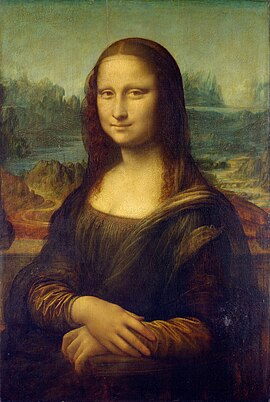

['person']

In [103]:
def get_prediction(image_url, model):
    response = requests.get(image_url, stream=True)  # request to the image address, get response
    image = Image.open(response.raw)  # read raw bytes

    # model goes brrr
    image_transformed = T.ToTensor()(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prediction = model(image_transformed)[0]
    labels_predicted = prediction['labels'].data.cpu().numpy()
    scores = prediction['scores'].data.cpu().numpy()

    # get predictions
    labels_selected = labels_predicted[scores > SCORE_THRESHOLD]
    objects = [CATEGORIES[label_id] for label_id in labels_selected]
    
    image.show()

    return objects


get_prediction("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/270px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", model)

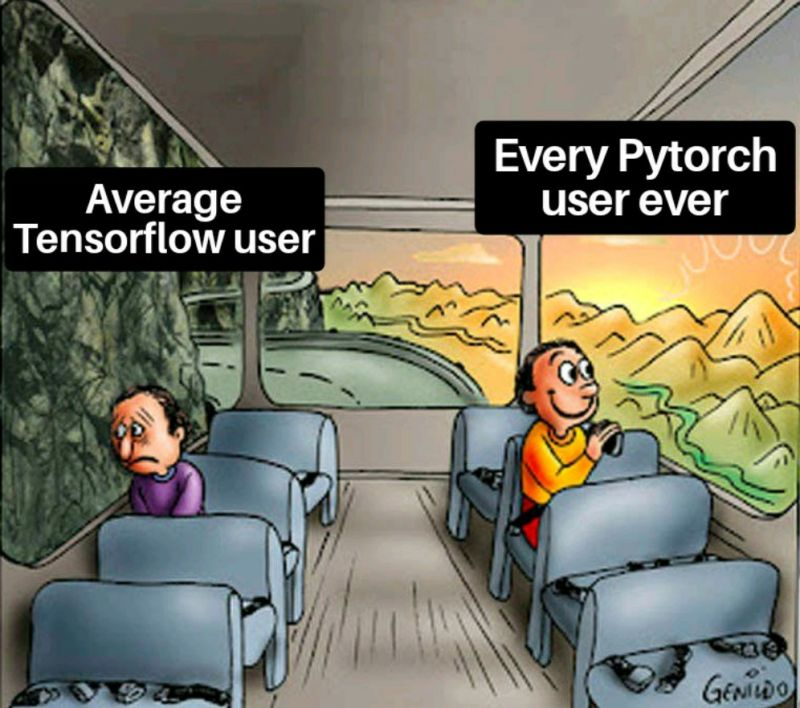

['chair', 'person', 'chair', 'chair', 'chair', 'chair']

In [104]:
get_prediction("https://media.licdn.com/dms/image/v2/C5622AQEfw4J2wKWv8A/feedshare-shrink_800/feedshare-shrink_800/0/1642765164511?e=2147483647&v=beta&t=2CH5JXpPyOIbF1qCN1eFKTWN16-W38bhIO7l5LP_Mfc", model)

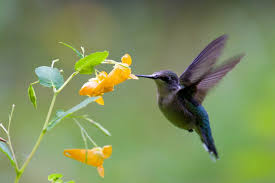

['bird']

In [105]:
get_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTPMiNrFTdy4vYgOcjhcN6PPqEVB08V3KdQ2A&s", model)

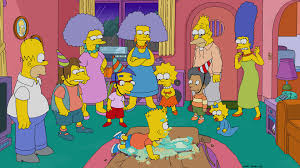

['person', 'person']

In [106]:
get_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ92tpDktYrkx4camlJR3yUpXI5_ElqdZfKWA&s", model)

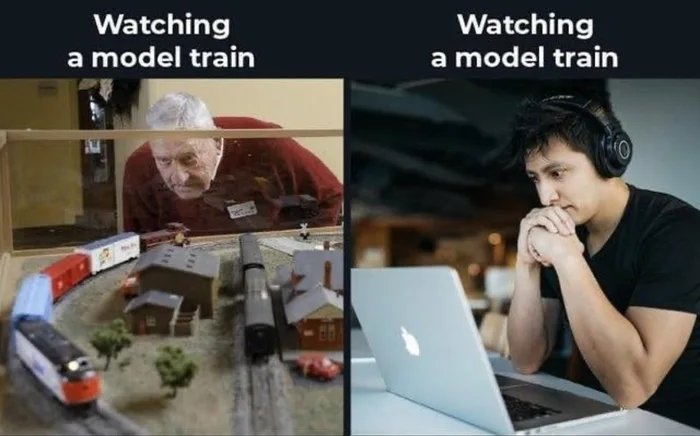

['laptop', 'person', 'person', 'train', 'car']

In [107]:
get_prediction("https://i.redd.it/j586af7nxvu41.jpg", model)